# Approximate Bayesian Neural Operator

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
from functools import reduce
import os
from timeit import default_timer
from utilities import EarlyStopping,MatReader
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
### ---- Bayesian Linear Layer ---- ###
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.log_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_log_sigma = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        self.mu.data.normal_(0, 0.1)
        self.log_sigma.data.fill_(-3)
        self.bias_mu.data.zero_()
        self.bias_log_sigma.data.fill_(-3)

    def forward(self, x):
        if self.training:
            weight = self.mu + torch.exp(self.log_sigma) * torch.randn_like(self.mu)
            bias = self.bias_mu + torch.exp(self.bias_log_sigma) * torch.randn_like(self.bias_mu)
        else:
            weight = self.mu
            bias = self.bias_mu
        return F.linear(x, weight, bias)

    def kl_loss(self):
        kl = 0.5 * torch.sum(torch.exp(2 * self.log_sigma) + self.mu**2 - 1 - 2 * self.log_sigma)
        kl += 0.5 * torch.sum(torch.exp(2 * self.bias_log_sigma) + self.bias_mu**2 - 1 - 2 * self.bias_log_sigma)
        return kl

In [4]:
### ---- Fourier Layers ---- ###
def compl_mul(a, b):
    return torch.einsum("bix,iox->box", a, b)

class SpectralConv(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.scale = 1 / (in_channels * out_channels)
        self.weights1_mean = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes1, dtype=torch.cfloat))
        self.weights1_logstd = nn.Parameter(-3 * torch.ones(in_channels, out_channels, modes1))

    def forward(self, x):
        x_ft = torch.fft.rfft(x, dim=-1, norm='ortho')
        eps = torch.randn_like(self.weights1_logstd)
        sampled_weights = self.weights1_mean + torch.exp(self.weights1_logstd) * eps
        sampled_weights = sampled_weights.to(torch.cfloat)
        out_ft = torch.zeros(x.size(0), self.out_channels, x.size(-1) // 2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1] = compl_mul(x_ft[:, :, :self.modes1], sampled_weights)
        return torch.fft.irfft(out_ft, n=x.size(-1), dim=-1, norm='ortho')


In [5]:
### ---- Network Blocks ---- ###
class SimpleBlock1d(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.modes1 = modes
        self.width = width

        self.fc0 = nn.Linear(2, width)

        self.conv0 = SpectralConv(width, width, modes)
        self.conv1 = SpectralConv(width, width, modes)
        self.conv2 = SpectralConv(width, width, modes)
        self.conv3 = SpectralConv(width, width, modes)

        self.w0 = nn.Conv1d(width, width, 1)
        self.w1 = nn.Conv1d(width, width, 1)
        self.w2 = nn.Conv1d(width, width, 1)
        self.w3 = nn.Conv1d(width, width, 1)

        self.bn0 = nn.BatchNorm1d(width)
        self.bn1 = nn.BatchNorm1d(width)
        self.bn2 = nn.BatchNorm1d(width)
        self.bn3 = nn.BatchNorm1d(width)

        self.fc1 = BayesianLinear(width, 128)
        self.fc2 = BayesianLinear(128, 1)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x = F.relu(self.bn0(self.conv0(x) + self.w0(x)))
        x = F.relu(self.bn1(self.conv1(x) + self.w1(x)))
        x = F.relu(self.bn2(self.conv2(x) + self.w2(x)))
        x = self.bn3(self.conv3(x) + self.w3(x))

        x = x.permute(0, 2, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def kl_loss(self):
        return self.fc1.kl_loss() + self.fc2.kl_loss()

In [6]:
class Net1d(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.conv1 = SimpleBlock1d(modes, width)

    def forward(self, x):
        return self.conv1(x).squeeze()

    def kl_loss(self):
        return self.conv1.kl_loss()

    def count_params(self):
        return sum(p.numel() for p in self.parameters())

In [77]:
# def predict_with_uncertainty(model, x, n_samples=100):
#     model.train()
#     preds = [model(x).unsqueeze(0) for _ in range(n_samples)]
#     return torch.cat(preds, dim=0)

# def visualize_uncertainty(x, y_true, pred_samples):
#     pred_mean = pred_samples.mean(0).detach().cpu().numpy()
#     pred_std = pred_samples.std(0).detach().cpu().numpy()

#     plt.figure(figsize=(10, 5))
#     plt.plot(y_true.cpu().numpy().flatten(), label='Ground Truth')
#     plt.plot(pred_mean.flatten(), label='Mean Prediction')
#     plt.fill_between(np.arange(len(pred_mean.flatten())),
#                      pred_mean.flatten() - 2 * pred_std.flatten(),
#                      pred_mean.flatten() + 2 * pred_std.flatten(), alpha=0.3, label='±2 Std')
#     plt.legend()
#     plt.title("Prediction with Uncertainty")
#     plt.show()

def visualize_uncertainty(y_true, pred_samples):
    
    pred_mean = pred_samples.mean(0).detach().cpu().numpy()
    pred_std = pred_samples.std(0).detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    
    x_axis = np.arange(len(pred_mean.flatten()))

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=x_axis,
        y=y_true.flatten(),
        mode='lines',
        name='Ground Truth',
        line=dict(color='blue')
    ))

    fig.add_trace(go.Scatter(
        x=x_axis,
        y=pred_mean.flatten(),
        mode='lines',
        name='Mean Prediction',
        line=dict(color='orange')
    ))

    fig.add_trace(go.Scatter(
        x=np.concatenate([x_axis, x_axis[::-1]]),
        y=np.concatenate([pred_mean.flatten() + 2 * pred_std.flatten(),
                          (pred_mean.flatten() - 2 * pred_std.flatten())[::-1]]),
        fill='toself',
        fillcolor='rgba(255,165,0,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=True,
        name='±2 Std Dev'
    ))

    fig.update_layout(
        title="Prediction with Uncertainty",
        xaxis_title="Index",
        yaxis_title="Value",
        hovermode="x",
        template="plotly_white"
    )

    fig.show()

In [46]:
### ---- Configs ---- ###
sub = 8
h = 2**10 // sub
s = h

batch_size = 32
learning_rate = 0.001
epochs = 200
step_size = 100
gamma = 0.5
modes = 16
width = 64
kl_beta = 1e-4

In [ ]:
### ---- Load Data ---- ###
dataloader = MatReader('data/burgers_data_R10.mat')
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]

total_sampels = x_data.shape[0]
ntrain = int(0.8 * total_sampels)
ntest = total_sampels - ntrain
nval=int(0.1 * ntrain)
ntrain=ntrain - nval

# prepare train/test splits (as in your original script)
x_train = x_data[:ntrain, ::sub]
y_train = y_data[:ntrain, ::sub]
x_val= x_data[ntrain:ntrain+nval, ::sub]
y_val= y_data[ntrain:ntrain+nval, ::sub]
x_test = x_data[-ntest:, ::sub]
y_test = y_data[-ntest:, ::sub]

grid = np.linspace(0, 2*np.pi, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)
x_val = torch.cat([x_val.reshape(nval,s,1), grid.repeat(nval,1,1)], dim=2)
x_test = torch.cat([x_test.reshape(ntest,s,1), grid.repeat(ntest,1,1)], dim=2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val, y_val), batch_size=batch_size)

In [55]:
x_train.shape,x_val.shape,x_test.shape  

(torch.Size([1475, 128, 2]),
 torch.Size([163, 128, 2]),
 torch.Size([410, 128, 2]))

In [56]:
os.makedirs('models/bno1d', exist_ok=True)

In [57]:
epochs=500

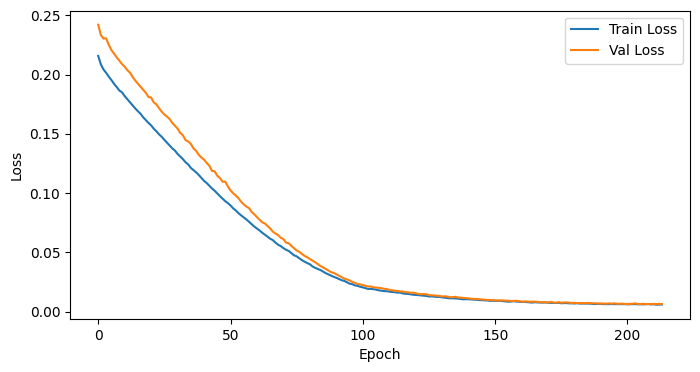

Epoch 213/500: Time=0.60s, Train MSE+KL=0.005931297641689494, Val MSE+KL=0.006352
EarlyStopping counter: 5 out of 5
We are at epoch: 214


In [59]:
### ---- Train ---- ###
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net1d(modes, width).to(device)
print("Parameter Count:", model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
early_stopping = EarlyStopping(patience=5, verbose=True, path='models/bno1d/bno1d_checkpoint.pt', trace_func=print)

mse = nn.MSELoss()
train_losses = []
val_losses = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = val_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)

        mse_val = mse(out, y)
        kl = 0.0
        for module in model.modules():
            if hasattr(module, 'kl_loss'):
                kl += module.kl_loss()

        loss = mse_val + kl_beta * kl
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    scheduler.step()

    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            kl = 0.0
            for module in model.modules():
                if hasattr(module, 'kl_loss'):
                    kl += module.kl_loss()
            loss=mse(out.view(out.shape[0], -1), y.view(out.shape[0], -1)) + kl_beta * kl
            val_loss += loss.item()

    train_loss /= ntrain
    val_loss /= nval
    train_losses.append(train_loss)
    val_losses.append(val_loss) 
    t2 = default_timer()
    early_stopping(val_loss=val_loss,model=model)
    if early_stopping.early_stop:
        print("We are at epoch:", ep)
        break
    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(f"Epoch {ep}/{epochs}: Time={t2 - t1:.2f}s, Train MSE+KL={train_loss}, Val MSE+KL={val_loss:.6f}")


In [60]:
# === Evaluation & Metrics (per-sample + aggregate) ===
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os


# Ensure eval mode
model.train()
preds = []
gts = []
rel_l2_list = []
mse_list = []
mae_list = []
rmse_list = []
r2_list = []

with torch.no_grad():
    for idx, (x, y) in enumerate(zip(x_test, y_test)):
        x= x.unsqueeze(0).cuda()
        out = model(x).cpu() 
        gts.append(y.numpy())
        preds.append(out.numpy())
        mse = mean_squared_error(y.flatten(), out.flatten())
        mae = mean_absolute_error(y.flatten(), out.flatten())
        rmse = np.sqrt(mse)
        r2 = r2_score(y.flatten(), out.flatten())

        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Sample {idx:3d} | MSE: {mse:.6e} | RMSE: {rmse:.6e} | MAE: {mae:.6e} | R2: {r2:.4f}")


# summary
def summarize(metric_list, name):
    arr = np.array(metric_list)
    print(f"{name:10s} => mean: {np.mean(arr):.6e}    std: {np.std(arr):.6e}    median: {np.median(arr):.6e}")

print("\\n=== Summary over test set ===")
summarize(rel_l2_list, "rel-L2")
summarize(mse_list,   "MSE")
summarize(rmse_list,  "RMSE")
summarize(mae_list,   "MAE")
summarize(r2_list,    "R2")

# # save results to .mat
# sio.savemat('pred/burger_test_metrics.mat', {
#     'pred': preds, 'gt': gts,
#     'rel_l2_list': np.array(rel_l2_list),
#     'mse_list': np.array(mse_list),
#     'mae_list': np.array(mae_list),
#     'rmse_list': np.array(rmse_list),
#     'r2_list': np.array(r2_list)
# })
# print("Saved predictions + metrics to pred/burger_test_metrics.mat")


Sample   0 | MSE: 1.085490e-01 | RMSE: 3.294678e-01 | MAE: 2.847187e-01 | R2: -0.7456
Sample   1 | MSE: 8.614034e-02 | RMSE: 2.934967e-01 | MAE: 2.408502e-01 | R2: -0.7735
Sample   2 | MSE: 2.349529e-02 | RMSE: 1.532817e-01 | MAE: 1.052157e-01 | R2: 0.9272
Sample   3 | MSE: 6.351115e-02 | RMSE: 2.520142e-01 | MAE: 2.091581e-01 | R2: -0.5655
Sample   4 | MSE: 6.512383e-02 | RMSE: 2.551937e-01 | MAE: 2.385484e-01 | R2: -0.1270
Sample   5 | MSE: 1.657434e-02 | RMSE: 1.287414e-01 | MAE: 1.110925e-01 | R2: 0.8102
Sample   6 | MSE: 9.499947e-02 | RMSE: 3.082198e-01 | MAE: 2.923593e-01 | R2: 0.1305
Sample   7 | MSE: 3.322554e-02 | RMSE: 1.822788e-01 | MAE: 1.403148e-01 | R2: 0.6934
Sample   8 | MSE: 2.618186e-01 | RMSE: 5.116821e-01 | MAE: 4.223672e-01 | R2: 0.6796
Sample   9 | MSE: 1.813086e-02 | RMSE: 1.346509e-01 | MAE: 1.015149e-01 | R2: 0.8938
Sample  10 | MSE: 1.000077e-02 | RMSE: 1.000038e-01 | MAE: 8.765891e-02 | R2: 0.9583
Sample  11 | MSE: 1.629303e-01 | RMSE: 4.036462e-01 | MAE: 3.

/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [61]:
results={
    'mse':np.mean(mse_list),
    'rmse':np.mean(rmse_list),
    'mae':np.mean(mae_list),
    'r2':np.mean(r2_list),
    'pred': np.array(preds), 'gt':np.array(gts),
    'rel_l2_list': np.array(rel_l2_list),
    'mse_list': np.array(mse_list),
    'mae_list': np.array(mae_list),
    'rmse_list': np.array(rmse_list),
    'r2_list': np.array(r2_list)
}
import pickle
pickle.dump(results, open('models/bno1d/burger_test_metrics.pickle', 'wb'))

In [62]:
results=pickle.load(open('models/bno1d/burger_test_metrics.pickle', 'rb'))

In [63]:
preds=results['pred']
gts=results['gt']

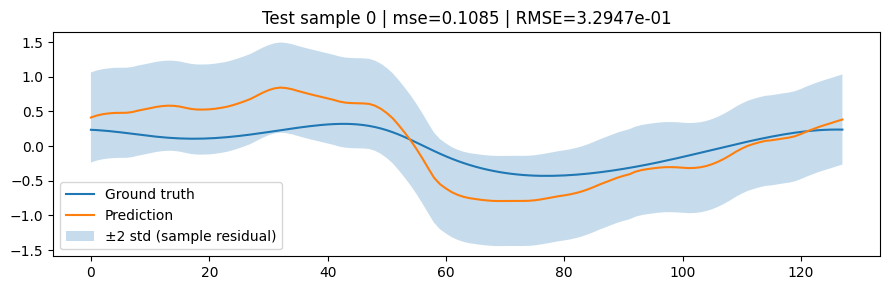

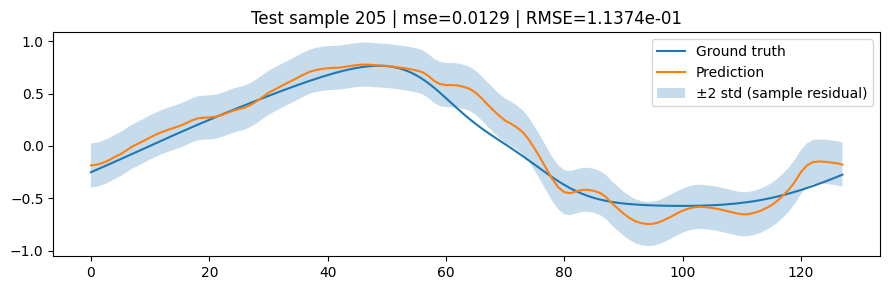

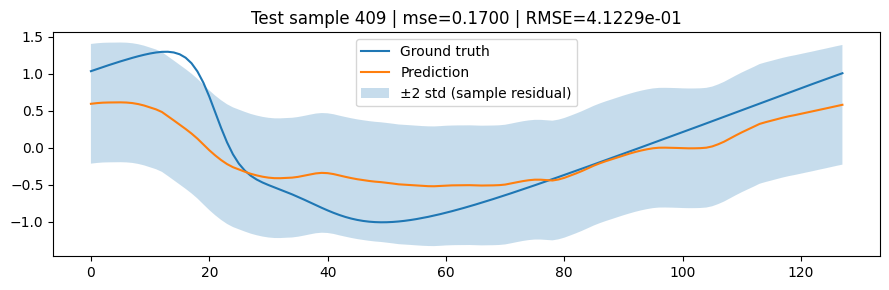

In [64]:
# === Plot example test samples (first, middle, last) ===
example_idxs = [0, len(preds)//2, len(preds)-1]
x_axis = np.arange(preds.shape[1])

for ex in example_idxs:
    plt.figure(figsize=(9,3))
    plt.plot(x_axis, gts[ex], label='Ground truth')
    plt.plot(x_axis, preds[ex], label='Prediction')
    resid = preds[ex].flatten() - gts[ex].flatten()
    plt.fill_between(x_axis,
                     preds[ex].flatten() - 2*np.std(resid),
                     preds[ex].flatten() + 2*np.std(resid),
                     alpha=0.25, label='±2 std (sample residual)')
    plt.title(f"Test sample {ex} | mse={mse_list[ex]:.4f} | RMSE={rmse_list[ex]:.4e}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [100]:
gts_flattened = gts.flatten()
pred_flatten=preds.flatten()
pred_mean=preds.mean()
pred_std=preds.std()

In [107]:
fig=go.Figure()
fig.add_trace(go.Scatter(y=gts_flattened, mode='lines', name='Ground Truth'))
fig.add_trace(go.Scatter(y=pred_flatten, mode='lines', name='Prediction'))
# Uncertainty band
fig.add_trace(go.Scatter(
    y=(pred_flatten + pred_std.flatten()),
    mode='lines',
    line=dict(width=0),
    name='Upper Bound',
    showlegend=False
))
fig.add_trace(go.Scatter(
    y=( pred_flatten - pred_std.flatten()),
    mode='lines',
    line=dict(width=0),
    name='Lower Bound',
    fill='tonexty',
    fillcolor='rgba(0,100,80,0.2)',
    showlegend=True
))

fig.update_layout(
        title="Prediction with Uncertainty (Bayesian Neural Operator)",
        xaxis_title="Spatial grid index",
        yaxis_title="Solution value"
    )
# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="linear"
    )
)
fig.show()          

In [109]:
import plotly.graph_objects as go

def visualize_uncertainty_plotly(x, y_true, pred_samples, save_path=None):
    pred_mean = pred_samples.mean(0).detach().cpu().numpy()
    pred_std = pred_samples.std(0).detach().cpu().numpy()

    fig = go.Figure()

    # Ground truth
    fig.add_trace(go.Scatter(
        y=y_true.cpu().numpy().flatten(),
        mode='lines',
        name='Ground Truth'
    ))

    # Mean prediction
    fig.add_trace(go.Scatter(
        y=pred_mean.flatten(),
        mode='lines',
        name='Mean Prediction'
    ))

    # Uncertainty band
    fig.add_trace(go.Scatter(
        y=(pred_mean.flatten() + 2 * pred_std.flatten()),
        mode='lines',
        line=dict(width=0),
        name='Upper Bound',
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        y=(pred_mean.flatten() - 2 * pred_std.flatten()),
        mode='lines',
        line=dict(width=0),
        name='Lower Bound',
        fill='tonexty',
        fillcolor='rgba(0,100,80,0.2)',
        showlegend=True
    ))

    fig.update_layout(
        title="Prediction with Uncertainty (Bayesian Neural Operator)",
        xaxis_title="Spatial grid index",
        yaxis_title="Solution value"
    )

    if save_path:
        fig.write_image(save_path)  # save as PNG/PDF/SVG

    fig.show()

In [110]:
x_test_device = x_test.to(device)
y_test_device = y_test.to(device)   
with torch.no_grad():
    n_samples = 100
    pred_samples = []
    for _ in range(n_samples):
        preds_sample = model(x_test.to(device)).cpu().unsqueeze(0)
        pred_samples.append(preds_sample)
    pred_samples = torch.cat(pred_samples, dim=0)
visualize_uncertainty_plotly(x_test_device[..., 0], y_test_device, pred_samples)